# Exploratory Data Analysis

In this notebook, I'll focus on finding patterns in time series data about global, household power consumption. The idea is to see if it's feasible to use past, power usage data to predict future usage—in other words, to see if there are noticeable patterns that may be useful for implementing an ML or DL-based solution to this problem. 

**Data**: [Household Power Consumption dataset on Trove](https://trove.apple.com/dataset/household_power_consumption/1.0.0)


> **Predictive goal**: Predict future active power that a household will need on an hourly basis (e.g, at 9am, 10am, etc.) with high accuracy. The best predictions will avoid underestimating the active power. 

>**Hypothesis**: I think power meter readings and _past_ hourly usage will be great predictors for an ML model. 

**A bit of background research**: A related project, recently done by Google and DeepMind, uses machine learning to predict the *generation* of power by wind turbines and efficiently deliver power to the grid. You can read about that research, [in this post](https://deepmind.com/blog/machine-learning-can-boost-value-wind-energy/).

## Machine learning workflow

Once I have framed my problem with a predictive goal and hypothesis, I follow a series of steps to see if I can develop a simple, baseline solution, which I can use for comparison as I develop more complex solutions, later on. The steps in this notebook are roughly broken down as:
1. Data loading and initial exploration
2. More exploration (asking and answering questions that may be useful for making the prediction I want)
3. Getting rid of missing or null values

Later, I plan to complete this workflow: 
* Transforming data in preparation for training
* Splitting data into train and test sets
* Training and evaluating a simple, linear regression model as a baseline solution
* Trying to improve upon a baseline solution with additional input features and/or deep learning techniques

📍You'll also notice that I leave notes to myself throughout this notebook; notes on data observations and on things to try in experiments later. I hope you find these ruminations helpful!


---

Let's start by loading in the usual resources.

In [1]:
# basic data viz and processing libraries
import turitrove as trove
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline


!! Could not derive your terminal width !!


---
# Mount the Data

We'll be mounting some data from Trove about global energy consumption, collected over a few years. You can read about the dataset on Trove directly—the description provides information about how this data is formatted and how it was collected, so a first step of reading this description is ALWAYS valuable!

>Read about the [Household Power Consumption dataset on Trove](https://trove.apple.com/dataset/household_power_consumption/1.0.0).

In [2]:
TROVE_URI = 'dataset/household_power_consumption@1.0.0'

# use trove.umount() to clean up the mount from any prior mounts
trove.umount(TROVE_URI)

# create local temp_data dir and mount data there
if not os.path.isdir('temp_data'):
    os.makedirs('temp_data')
    
power_dataset = trove.mount(TROVE_URI, 'temp_data')

dataset/household_power_consumption@1.0.0 is not mounted
Directory /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/data is created by trove.
mount in progress: /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/data/table
26.4KB disk space allocated for caching /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/data/table


N/A% (0 of 100) |                                        |Elapsed Time: 0:00:00


Mount succeeded
mount in progress: /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/data/raw
96.9MB disk space allocated for caching /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/data/raw


100% (100 of 100) |######################################|Elapsed Time: 0:00:00


Mount succeeded
dataset/household_power_consumption@1.0.0 is mounted at /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data


In [3]:
# print index to see if mounted correctly, should see a txt filename
power_dataset.primary_index


filename,id,path,md5,mod_time,size
power_consumption.txt,0,power_consumption.txt,73b69bc973cb00f2cfbab68b48470ba1 ...,1620410940.395498,101631006


### Read in the `.txt` file

The next cell displays the first few lines in the text file, so we can see how it is formatted.

In [4]:
# display first ten lines of text data
data_path = power_dataset.raw_file_path + '/'+ power_dataset.primary_index['path'][0]

n_lines = 10

with open(data_path) as file:
    head = [next(file) for line in range(n_lines)]
    
display(head)

['Date;Time;Global_active_power;Voltage;Sub_metering_1;Sub_metering_2;Sub_metering_3\n',
 '16/12/2006;17:24:00;4.216;234.840;0.000;1.000;17.0\n',
 '16/12/2006;17:25:00;5.360;233.630;0.000;1.000;16.0\n',
 '16/12/2006;17:26:00;5.374;233.290;0.000;2.000;17.0\n',
 '16/12/2006;17:27:00;5.388;233.740;0.000;1.000;17.0\n',
 '16/12/2006;17:28:00;3.666;235.680;0.000;1.000;17.0\n',
 '16/12/2006;17:29:00;3.520;235.020;0.000;2.000;17.0\n',
 '16/12/2006;17:30:00;3.702;235.090;0.000;1.000;17.0\n',
 '16/12/2006;17:31:00;3.700;235.220;0.000;1.000;17.0\n',
 '16/12/2006;17:32:00;3.668;233.990;0.000;1.000;17.0\n']

📝 **What I notice:**
* This text file has data separated by semicolons
* It contains Date and Time columns, which I might want to use for indexing

This initial exploration gives me enough information to effectively read in the file using pandas `read_csv` function. pandas makes it easy for me to take next exploratory steps. 

## Read in data with `read_csv()`

You can check out the extensive [`read_csv()` function documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), but the important parameters to know are:
* `read_csv()` takes in a file path

This is the only argument that is strictly required to read in data as a DataFrame.  The rest of these are optional but useful for messier or time-series data. 

* `sep` is the character(s) that file uses to separate values; the default is a comma `','`, but you can specify other separating characters like a semicolon `';'`
* `na_values` is a list of values in the data that should be interpreted as null or empty values
* `dtype` is a dictionary that allows you to specify the data type for each column in the data, by name
* (Not shown below) `parse_dates={'Date-Time' : ['Date', 'Time']}`,  and `infer_datetime_format=True` can help you read in the two Date and Time columns as one complete, Date-Time index, but we can also do that later

Note: by specifying dtypes, I was able to find the null/na values, `na_vals = ['nan', '?']`.

**Try it yourself**: Try removing the na_vals but keeping the rest of the read_csv arguments. What happens?


In [5]:
# this is semi-colon separated, so let's use that to read this in as a DataFrame
sep = ';'
na_vals = ['nan', '?']

df = pd.read_csv(data_path, sep=sep, na_values = na_vals,
                dtype={'Global_active_power': float, 
                        'Voltage': float,
                        'Sub_metering_1': float,
                        'Sub_metering_2': float,
                        'Sub_metering_3': float
                       })


---
# Asking (and Answering) Questions

Once we've read in the data, we can begin to explore. Exploration is best when it is intentional and you have specific questions or relationships that you are interested in learning more about. I think about exploratory data analysis as a set of steps and tools you can use to answer questions about data.

Let's start with some simple, initial questions about the dataset.
* How much data do I have to work with?
* What are the data types?

I can answer these questions by getting some information from my DataFrame, `df`. 
* I can look at the size of my DataFrame using the `.shape` *attribute*, and 
* I can look at a few of the top rows of the data with the function `.head()`. 


**Attributes** are properties of the DataFrame itself, and **functions** are things I can call on an object; they are similar but functions have the `()` syntax and you can often pass useful arguments into these parentheses. For example, you can pass in a specified number of rows to print to `.head(n_rows)`. 

I already know the types of data in this df, since I read every value in as a float value (a standard type for decimal values), but I can also review them after reading in some data, using the attribute `dtypes`.

In [6]:
# print the shape of the data and a few of the top rows
print('Shape: ', df.shape)
print()
df.head()

Shape:  (2075259, 7)



,Date,Time,Global_active_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,234.84,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,233.63,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,233.29,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,233.74,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,235.68,0.0,1.0,17.0


In [7]:
df.dtypes


Date                    object
Time                    object
Global_active_power    float64
Voltage                float64
Sub_metering_1         float64
Sub_metering_2         float64
Sub_metering_3         float64
dtype: object

📝 **What I notice:**
* All values are floats except Date and Time, which are general objects that I may need to specify as DateTime objects in future.

## From high-level to low-level questions

> **My task**: Next, I want to answer several, **high-level** questions about this data to see what patterns may be useful for helping me to make predictions about future, power usage. 
1. What is a typical range for power usage in a household? 
2. How does power usage change over time for a household?
3. How do sub meter readings relate to active power usage?

> ### Question 1: What is a typical range for power usage in a household?

Question 1 can be re-phrased as a couple **low-level** questions, which are more specific and easier to turn into code:
* What is the average value of power usage in this data and what is the standard deviation from this mean?
* What are the min and max values for power usage in this data?

Averages, standard deviations, and min/max values are all very standard statistical values that can be calculated for any numeric column of data. 
>In fact, pandas provides a simple way to calculate and view many common statistics using the `describe()` function on a DataFrame.

In [8]:
df.describe()

,Global_active_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,2.408399e+02,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,3.239987e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,2.232000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,2.389900e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,2.410100e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,2.428900e+02,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,2.541500e+02,8.800000e+01,8.000000e+01,3.100000e+01


📝 **What I notice:**
* The mean value for `Global_active_power` is 1.091615
* The std dev is 1.057294, which indicates a fairly narrow spread of typical values
* However, the min is very close to 0 at 0.076 and the max usage is at 11.122; several deviations away from the mean. 

Note that the summary notation records all values as X.XXe__ where e+01 means that you move the decimal to the right by one, and e-02 means you move the decimal to the left by 2. 

The other values in this summary table represent a **count** of all non-null values in that column, and **quantiles** which effectively show a number like 1.528 that 75% of all active power values fall under.  

## Data visualization: histograms

Another way to understand the average and spread of data is through the usage of a distribution or **histogram** plot, which buckets a columns values into common ranges and counts up the occurrences in each bucket. 
* I typically use `plt.hist()` passing in a particular column name that I am interested in, or
* I convert my DataFrame into an SFrame which is compatible with a library called `turicreate`'s GREAT visualization tools and the `.show()` function

Both of these methods are shown below.

(array([1.037237e+06, 1.641800e+05, 4.511820e+05, 1.525620e+05,
        9.922700e+04, 5.225600e+04, 4.232500e+04, 2.142700e+04,
        1.217500e+04, 7.382000e+03, 4.815000e+03, 2.263000e+03,
        1.042000e+03, 6.360000e+02, 3.760000e+02, 1.130000e+02,
        4.800000e+01, 2.400000e+01, 7.000000e+00, 3.000000e+00]),
 array([ 0.076 ,  0.6283,  1.1806,  1.7329,  2.2852,  2.8375,  3.3898,
         3.9421,  4.4944,  5.0467,  5.599 ,  6.1513,  6.7036,  7.2559,
         7.8082,  8.3605,  8.9128,  9.4651, 10.0174, 10.5697, 11.122 ]),
 <BarContainer object of 20 artists>)

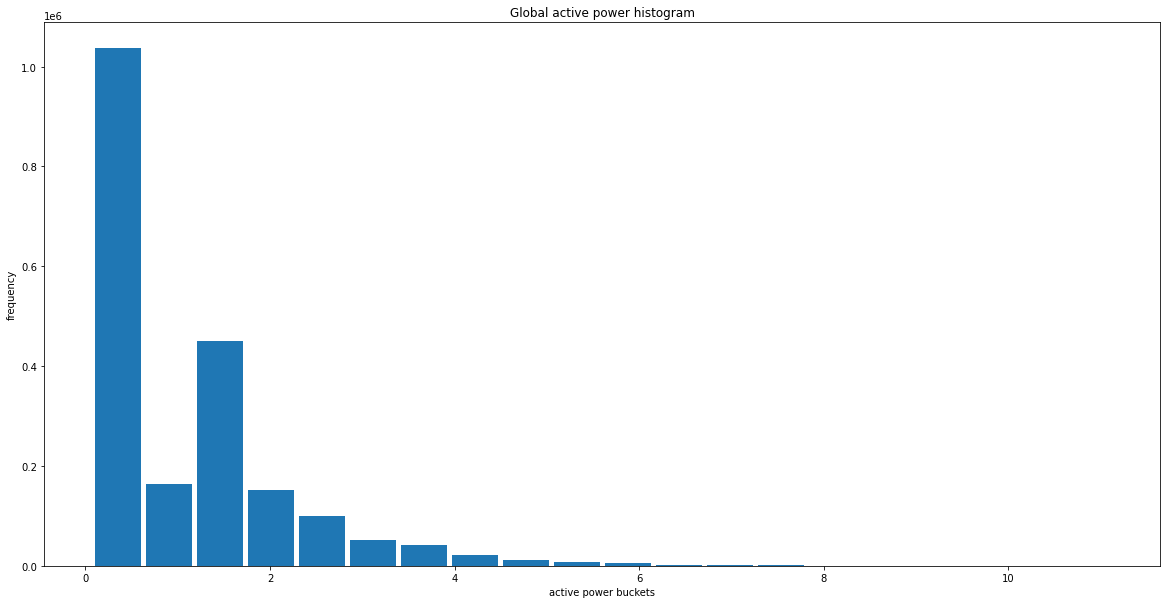

In [9]:
# matplotlib figure

# size and title of figure
plt.figure(figsize=(20,10))
plt.xlabel('active power buckets')
plt.ylabel('frequency')
plt.title('Global active power histogram')

# prints out the  counts in each bucket and the start/end range for a bucket of values
plt.hist(df['Global_active_power'], bins = 20, rwidth=0.9)

In [10]:
## Turicreate method

# convert to SFrame 
import turicreate as tc

df_sframe = tc.SFrame(df) 

# look at dist of all values using .show()
df_sframe.show()

Materializing SFrame

### Observations 📝

**What I notice:**
* The target var is left-skewed, meaning it is mostly around 0-1.5 and then there are a few power usage values in the 2-6ish range
* This visualization aligns with the quantiles in the summary stats that say that 75% of the Global_active_power data is within 1.528 and the mean and std. dev are both around 1

Again, if you need a refresher on these statistical measures and how they are created or what they mean; I recommend perusing [this series of videos from Khan Academy](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data). Having a handle on basic statistics is really useful for being an ML engineer; I use quantiles all the time to summarize data and understand distributions without having to do more intensive visualizations. 



---
# Dealing with Null Values

Before I move on to answering other questions with the data, I am going to deal with the missing values that I identified earlier: `['nan, '?']`.

First, I'll see how _many_ missing values I have because that will help me determine whether I can delete them entirely (without throwing away too much information) or whether I should replace these values with values that make sense in this context. 

In [11]:
# finding null values (sum gives a count of any nulls found in each column)
df.isnull().sum()

Date                       0
Time                       0
Global_active_power    25979
Voltage                25979
Sub_metering_1         25979
Sub_metering_2         25979
Sub_metering_3         25979
dtype: int64

In [12]:
df.shape

(2075259, 7)

In [13]:
# looking at a few null rows
null_rows = df[df.isna().any(axis=1)]
null_rows

,Date,Time,Global_active_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,NaN,NaN,NaN,NaN,NaN
6840,21/12/2006,11:24:00,NaN,NaN,NaN,NaN,NaN
19724,30/12/2006,10:08:00,NaN,NaN,NaN,NaN,NaN
19725,30/12/2006,10:09:00,NaN,NaN,NaN,NaN,NaN
41832,14/1/2007,18:36:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1990185,28/9/2010,19:09:00,NaN,NaN,NaN,NaN,NaN
1990186,28/9/2010,19:10:00,NaN,NaN,NaN,NaN,NaN
1990187,28/9/2010,19:11:00,NaN,NaN,NaN,NaN,NaN
1990188,28/9/2010,19:12:00,NaN,NaN,NaN,NaN,NaN


### Delete or impute? 

This is not _that_ much of the initial dataset, and so it would be very acceptable to delete these rows entirely.
However, there is another way to deal with missing values, which is also perfectly valid in this case: imputing (or replacing) these missing values with an aggregate statistic like the mean value for a column. 

This is especially useful for when you have a lot of missing values or when you plan to make calculations on this data that are less granular—I know that I want to look at hourly rather than minute-by-minute trends, and so replacing these values with a mean value should work well for my purposes. 


**DOCUMENTATION**: Pandas has some good documentation on dealing with missing data (and other topics), and I highly recommend checking out their documentation.
* [Here is a pandas documentation page, "Working with missing data"](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#).

In [14]:
# helper function to fill NaN values with a column average
def fill_nan_with_mean(df):
    '''Fills NaN values in a given dataframe with the average values in a column.
    
       :param df: a DataFrame that is assumed to contain cols of float values
       :return: returns a DataFrame with all null values replaced with the mean val for a column'''
    
    # filling nan with mean value of any columns
    for col in list(df.columns.values):  
        # ignoring date/time cols
        if col != 'Date' and col != 'Time':
            df[col].iloc[:]=df[col].iloc[:].fillna(df[col].iloc[:].mean())
        
    return df
    

In [15]:
# using helper: fill NaN column values with *mean* column value
# Note: going to ignore SettingWithCopyWarning for now
clean_power_df = fill_nan_with_mean(df)

# check that this did indeed remove null vals
clean_power_df.isnull().sum()

/Users/cezannecamacho/opt/anaconda3/envs/deep-learning/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Date                   0
Time                   0
Global_active_power    0
Voltage                0
Sub_metering_1         0
Sub_metering_2         0
Sub_metering_3         0
dtype: int64

In [16]:
trove.umount(TROVE_URI)

dataset/household_power_consumption@1.0.0 is umounted from /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/data/table
dataset/household_power_consumption@1.0.0 is umounted from /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/data/raw
folder /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/data is removed
terms.md is removed from /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/terms.md
readme.md is removed from /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/readme.md
info.json is removed from /Users/cezannecamacho/Desktop/Deep_Learning/DL_Notebooks_recording/temp_data/household_power_consumption-1.0.0/info.json



Data looking cleaned and great! Time to move on to further exploration.

**Note:** 📝 After some experimentation, it is common to turn all cleaning code into a python package that can be imported and re-used.

## Tip: Indexing by date-time

For time series data it is often really useful to index by date-time or reset_index() back to usual, numerical indices so you can access date-time values individually.

**DOCUMENTATION (and Stack Overflow)**

Again, there is some great documentation on these kinds of indexing steps, such as [this page on `set_index()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html), but for pandas I just as often find myself on Stack Overflow—a useful place to find answers to basic programming questions—after having searched for "pandas change index to date time..." or a related query.

In [17]:
# indexing by date-time for explorations
format_dates = '%d/%m/%Y %H:%M:%S'

# create one date-time index, converted to correct type
clean_power_df['Date-Time'] = pd.to_datetime(clean_power_df['Date']+' '+clean_power_df['Time'], format=format_dates)
#clean_power_df.drop(['Date', 'Time']) # drop old cols that were merged
clean_power_df = clean_power_df.set_index(pd.DatetimeIndex(clean_power_df['Date-Time']))
clean_power_df.head()


,Date,Time,Global_active_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date-Time
Date-Time,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,234.84,0.0,1.0,17.0,2006-12-16 17:24:00
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,233.63,0.0,1.0,16.0,2006-12-16 17:25:00
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,233.29,0.0,2.0,17.0,2006-12-16 17:26:00
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,233.74,0.0,1.0,17.0,2006-12-16 17:27:00
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,235.68,0.0,1.0,17.0,2006-12-16 17:28:00


---
# Back to Asking Questions and Exploring

Recall that my predictive goal is to predict the global active power usage some time in the future. And I had a question about past usage which may be able to help me figure out what patterns and information might be useful for prediction.

> ### Question 2: How does power usage change over time for a household?

Re-phrased as a low-level question: Looking at a day's worth of data, what are the power usage levels at each hour in the day?

Below, I am getting the entire `Global_active_power` column, and displaying the resultant plot. Indexing by date-time means the x-axis will automatically be the date. 

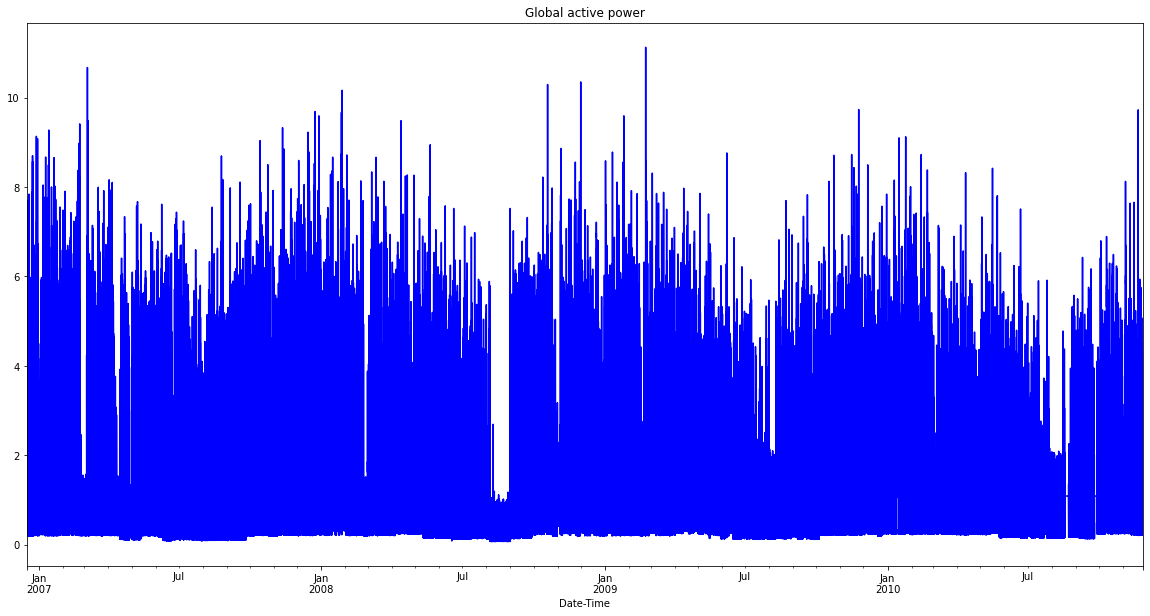

In [18]:
plt.figure(figsize=(20,10))

# selecting global active power column to plot, x-axis is automatically the date-time index
global_power_df = clean_power_df['Global_active_power']
global_power_df.plot(title='Global active power', color='blue') 
plt.show()

Since the data is recorded each minute, the above plot contains *a lot* of values. So, I'm going to plot just a day long slice of data below using python's list indexing and slicing features:
* `global_power_df[:end_mins].plot()` 

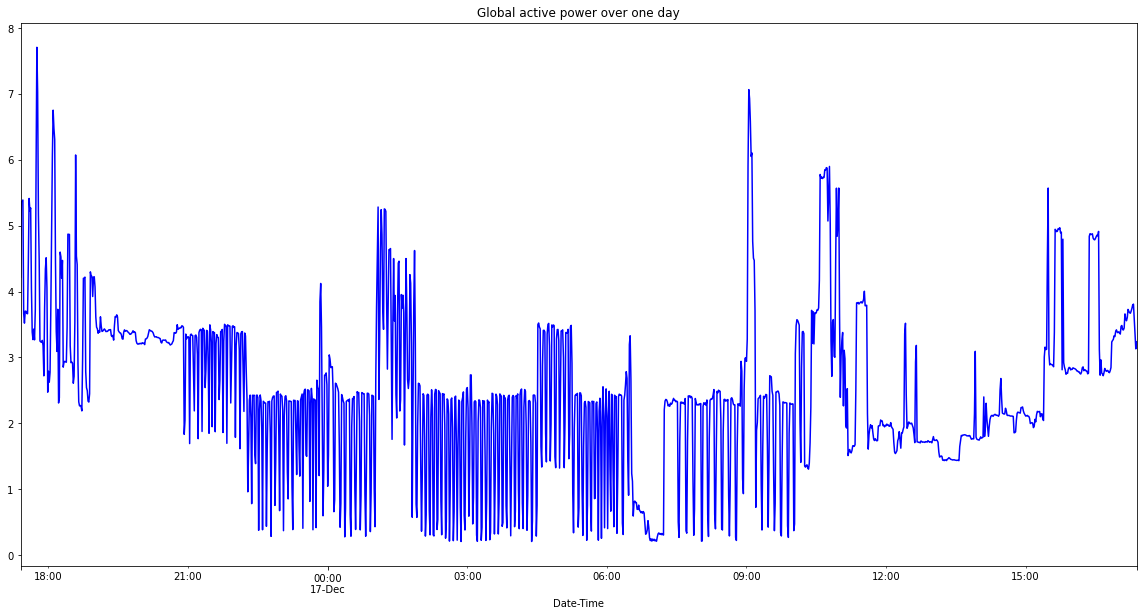

In [19]:
plt.figure(figsize=(20,10))

# plot about a day long slice of this data
end_mins = 60*24 # 60mins*24hrs a day = 1440 mins or 1 day
global_power_df[:end_mins].plot(title='Global active power over one day', color='blue')
plt.show()

### Hourly vs Daily

There is still a lot of data in the above plot, collected every minute, and so I could go one of two ways with my next, data transformations:
1. Create many, short time series, say a week or so long, in which I record energy consumption every **hour**, and try to predict the energy consumption over the following hours or days.
2. Create fewer, long time series with data recorded **daily** that I could use to predict usage in the following weeks or months.

Both are interesting! It depends on whether I want to predict time patterns over the hours in a day/week or over a longer time period, like a month. Recall that the power companies were interested in hour-by-hour trends, and their needs informed my next choice to resample the 'Global active power' values, recording **hourly** data points as averages over 60min-long periods.

> I can resample according to a specified frequency, by utilizing pandas [time series tools](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html), which allow me to sample at points like every hour ('H') or day ('D'), etc.



In [20]:
# resample every hour
freq = 'H'
# calculate the mean active power for a day
hourly_power_df = clean_power_df.resample(freq).mean()

hourly_power_df.head(10)

,Global_active_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date-Time,,,,,
2006-12-16 17:00:00,4.222889,234.643889,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,234.580167,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,233.232500,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,234.071500,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,237.158667,0.0,0.416667,17.216667
2006-12-16 22:00:00,2.200133,238.760000,0.0,0.133333,4.433333
2006-12-16 23:00:00,2.061600,240.619667,0.0,0.083333,0.000000
2006-12-17 00:00:00,1.882467,240.961833,0.0,0.466667,0.000000
2006-12-17 01:00:00,3.349400,240.448333,0.0,25.233333,0.000000


Finally I can answer my earlier question:

> ### Low-level question 2: Looking at a day's worth of data, what are the power usage levels at each hour in the day?

Below, I am plotting about a day long slice of data (24hrs).

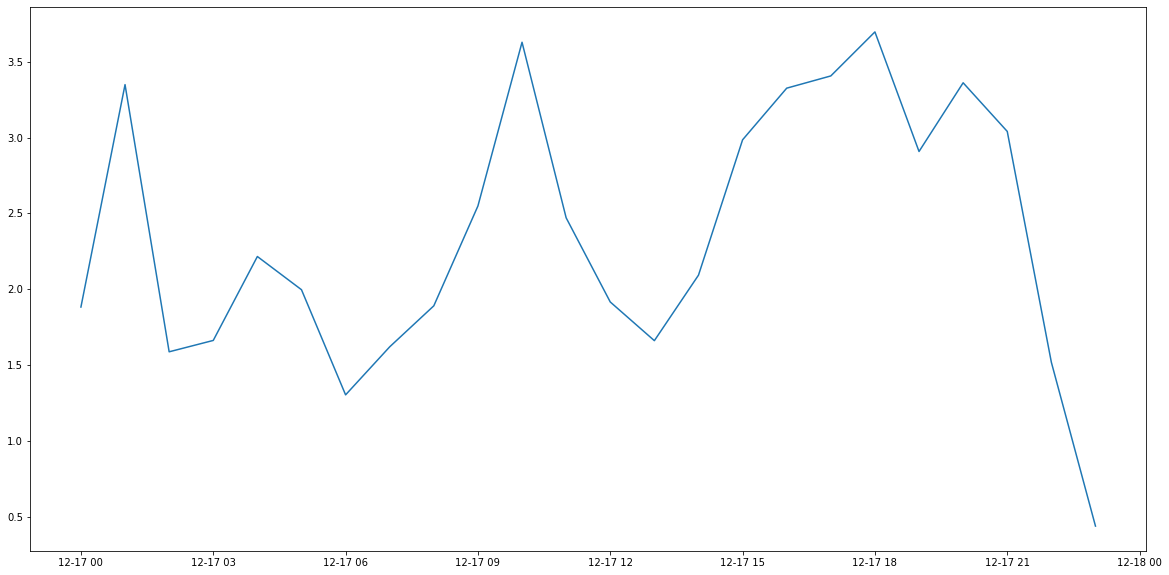

In [21]:
# plot day's worth of hourly-mean power usage
plt.figure(figsize=(20,10))

# plot about a day long slice of this data, starting at midnight
midnight_index= 7
end_hrs = 24 # 24hrs in a day

# default line graph
plt.plot(hourly_power_df.index[midnight_index:midnight_index+end_hrs], 
         hourly_power_df['Global_active_power'][midnight_index:midnight_index+end_hrs])

plt.show()

**Observations** 📝

In this single-day plot, I can already see some interesting patterns in these means. It seems that there are spikes of energy consumption around 9-10am, and a wider peak in the evening from about 4-9pm. Also a sharp peak (somewhat surprising to me) around 1am! 

The morning and evening usages are somewhat intuitive—these are times when many people may be waking up and using appliances/cookware, etc. to get ready for the day, or, similarly, watching TV, and turning on lamps in the evening when they are home from work or the daylight is ending. 

📍I suspect there would be seasonal variation that may be worth digging into here, too. 

I took a look at a few other days (not pictured though you are welcome to change the indices of the data to change the plot above), and noticed similar trends in morning and evening usage, which indicates that this is a good use case for machine learning models that may be able to recognize these recurring patterns and utilize them for making future predictions!

---
## Data visualizations: scatter plots

Finally, let's address the last question. 

> ###  Question 3: How do sub meter readings relate to active power usage?

Here, I need to specify what "relate" means. I could plot each sub_meter reading versus `Global_active_power` to graph their relationship, and draw insights from the shape of that relationship—it it curved? positive or negative (or neither)? etc.

I'll show an example of this, below.

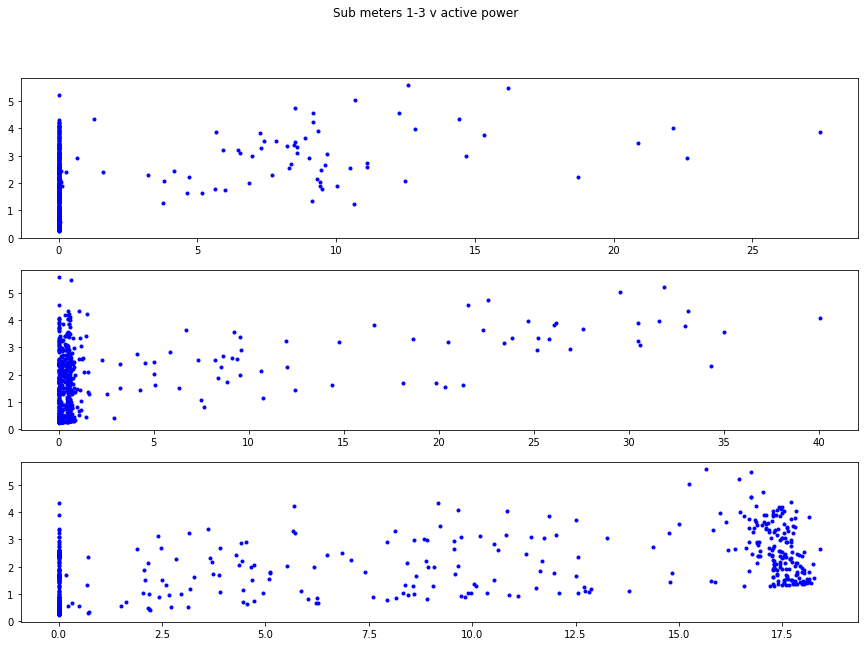

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,10))
fig.suptitle('Sub meters 1-3 v active power')

ax1.plot(hourly_power_df['Sub_metering_1'][0:600], hourly_power_df['Global_active_power'][0:600], 'b.')
ax2.plot(hourly_power_df['Sub_metering_2'][0:600], hourly_power_df['Global_active_power'][0:600], 'b.')
ax3.plot(hourly_power_df['Sub_metering_3'][0:600], hourly_power_df['Global_active_power'][0:600], 'b.')


These are a bit hard to read (and they are on different-legth axes!), but it looks like there is a slight positive relationship between all sub meter readings; e.g., if sub_meter 3 is high (right-side of the x-axis in the last plot), Global_active_power will be higher too. 

In [23]:
## (Optional) If you haven't already: unmount the Trove dataset

# uncomment this line
# trove.umount(TROVE_URI)
